Jacobian J(z):
 [[ 0.00052767 -0.04593685]
 [-0.10349521  0.13528046]]
Riemannian metric M(z) = JᵀJ:
 [[ 0.01071154 -0.01402512]
 [-0.01402512  0.020411  ]]


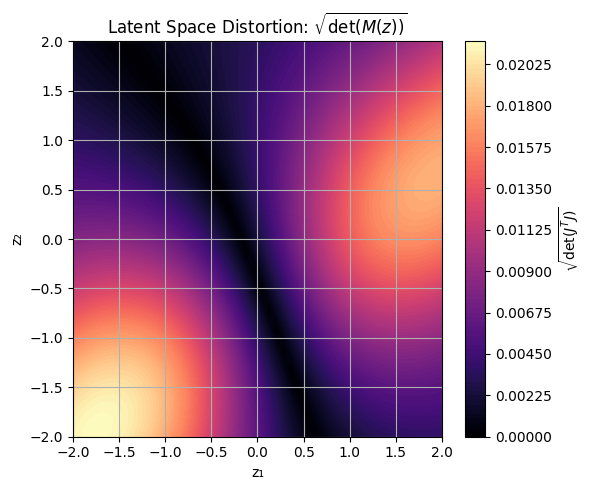

In [4]:
import torch
import torch.nn as nn
from torch.autograd import functional
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import functional
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad, functional
import matplotlib.pyplot as plt
import numpy as np

# Define a simple MLP Autoencoder with 2D latent space
class SimpleAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4), nn.Tanh(),
            nn.Linear(4, 2)  # z in ℝ²
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4), nn.Tanh(),
            nn.Linear(4, 2)  # x in ℝ²
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

# Instantiate the model and example input
ae = SimpleAE()
z = torch.tensor([[1.0, 0.0]], requires_grad=True)

# Forward pass through the decoder
x_hat = ae.decode(z)

# Compute Jacobian ∂f/∂z
def compute_jacobian(f, inputs):
    return functional.jacobian(f, inputs)

jac = compute_jacobian(lambda z: ae.decode(z), z)  # shape: (1, 2, 2)

# Compute M = JᵀJ
J = jac.view(2, 2)  # if you're sure output and input are both size 2
M = J.T @ J         # Riemannian metric at point z

print("Jacobian J(z):\n", J.detach().numpy())
print("Riemannian metric M(z) = JᵀJ:\n", M.detach().numpy())


# Simple Decoder: maps z ∈ ℝ² → x ∈ ℝ²
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 8), nn.Tanh(),
            nn.Linear(8, 2)
        )

    def forward(self, z):
        return self.model(z)

decoder = Decoder()

# Define distortion function using unbatched input
def compute_sqrt_det_metric(z):
    z = z.clone().detach().requires_grad_(True)
    jac = functional.jacobian(lambda z_: decoder(z_), z)  # shape: (2, 2)
    M = jac.T @ jac  # 2x2
    return torch.sqrt(torch.det(M)).item()

# Grid setup
grid_size = 50
z1 = torch.linspace(-2, 2, grid_size)
z2 = torch.linspace(-2, 2, grid_size)
Z1, Z2 = torch.meshgrid(z1, z2, indexing='ij')
volume_density = np.zeros((grid_size, grid_size))

# Compute distortion on grid
for i in range(grid_size):
    for j in range(grid_size):
        z = torch.tensor([Z1[i, j], Z2[i, j]], dtype=torch.float32)
        volume_density[i, j] = compute_sqrt_det_metric(z)

# Plot the distortion measure √det(JᵀJ)
plt.figure(figsize=(6, 5))
plt.contourf(Z1.numpy(), Z2.numpy(), volume_density, levels=100, cmap='magma')
plt.colorbar(label=r'$\sqrt{\det(J^T J)}$')
plt.title("Latent Space Distortion: $\sqrt{\det(M(z))}$")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
from torch.autograd import functional
import matplotlib.pyplot as plt
import numpy as np

# Simple VAE-style decoder: z ∈ ℝ² → (μ, logσ²) ∈ ℝ² × ℝ²
class VAE_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(2, 8), nn.Tanh()
        )
        self.mean_head = nn.Linear(8, 2)
        self.logvar_head = nn.Linear(8, 2)  # log(σ²)

    def forward(self, z):
        h = self.shared(z)
        mu = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mu, logvar

# Instantiate decoder
decoder = VAE_Decoder()

# Choose a latent point
z = torch.tensor([[1.0, 0.5]], requires_grad=True)

# Functions for μ(z) and σ(z)
def mu_fn(z):
    return decoder(z)[0]

def sigma_fn(z):
    logvar = decoder(z)[1]
    return torch.exp(0.5 * logvar)  # standard deviation σ(z)

# Compute Jacobians
J_mu = functional.jacobian(mu_fn, z).squeeze(1)      # shape: (2, 2)
J_sigma = functional.jacobian(sigma_fn, z).squeeze(1)  # shape: (2, 2)

# Riemannian metric M(z)
M = J_mu.T @ J_mu + J_sigma.T @ J_sigma

# Print results
print("J_mu(z):\n", J_mu.detach().numpy())
print("J_sigma(z):\n", J_sigma.detach().numpy())
print("Riemannian Metric M(z) = J_mu^T J_mu + J_sigma^T J_sigma:\n", M.detach().numpy())


J_mu(z):
 [[[[ 0.04348675  0.53655636]]

  [[-0.14341806 -0.0670384 ]]]]
J_sigma(z):
 [[[[ 0.06664973 -0.06507429]]

  [[-0.02135642 -0.15935221]]]]
Riemannian Metric M(z) = J_mu^T J_mu + J_sigma^T J_sigma:
 [[[[ 0.00633328  0.01899591]
   [-0.00766018 -0.07556211]]

  [[-0.00766018 -0.01353606]
   [ 0.02102484  0.01301771]]]


 [[[ 0.01899591  0.2921274 ]
   [-0.01353606 -0.02560015]]

  [[-0.07556211 -0.02560015]
   [ 0.01301771  0.02988728]]]]


Attempting to load MNIST dataset...
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 8.22MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.98MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.14MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Successfully loaded MNIST dataset.
Using device: cpu
Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 549.437195
Train Epoch: 1 [12800/60000 (21%)]	Loss: 195.107147
Train Epoch: 1 [25600/60000 (43%)]	Loss: 184.662430
Train Epoch: 1 [38400/60000 (64%)]	Loss: 185.381332
Train Epoch: 1 [51200/60000 (85%)]	Loss: 180.746307
====> Epoch: 1 Average loss: 190.9384
Train Epoch: 2 [0/60000 (0%)]	Loss: 173.493179
Train Epoch: 2 [12800/60000 (21%)]	Loss: 166.381119
Train Epoch: 2 [25600/60000 (43%)]	Loss: 160.220200
Train Epoch: 2 [38400/60000 (64%)]	Loss: 169.566650
Train Epoch: 2 [51200/60000 (85%)]	Loss: 164.719498
====> Epoch: 2 Average loss: 168.8854
Train Epoch: 3 [0/60000 (0%)]	Loss: 165.051010
Train Epoch: 3 [12800/60000 (21%)]	Loss: 164.713242
Train Epoch: 3 [25600/60000 (43%)]	Loss: 162.663589
Train Epoch: 3 [38400/60000 (64%)]	Loss: 165.405029
Train Epoch: 3 [51200/60000 (85%)]	Loss: 157.511703
====> Epoc

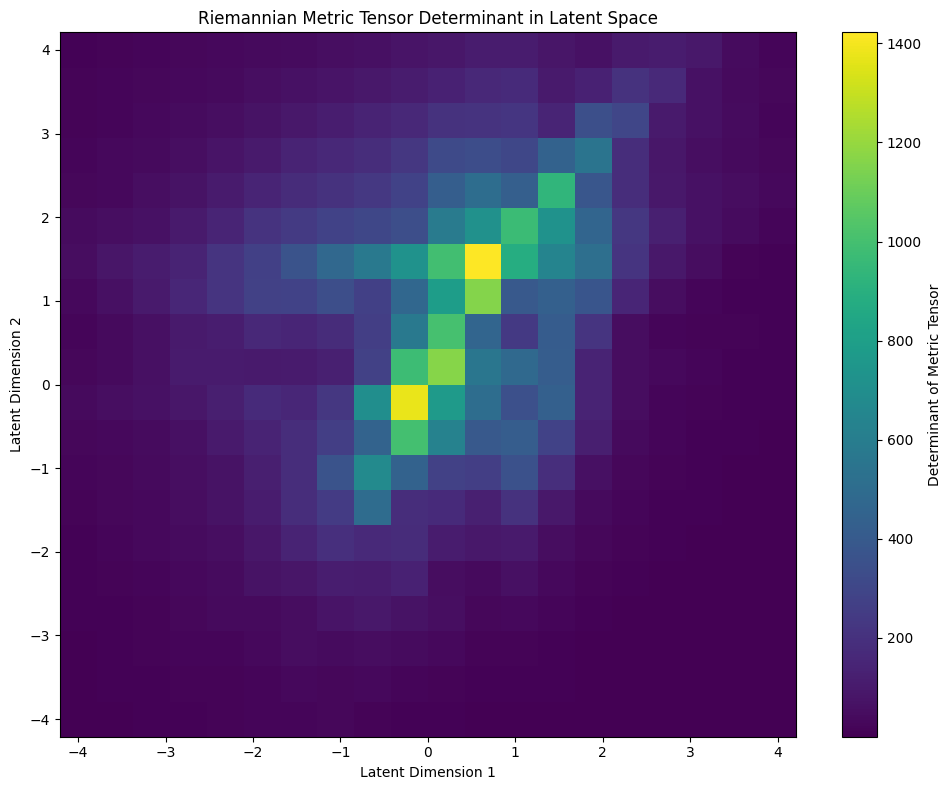


Christoffel symbols at origin (first few values):
[ 0.5331305  -0.13542859]

Approximated sectional curvature at origin: -7.505235298659415e-06


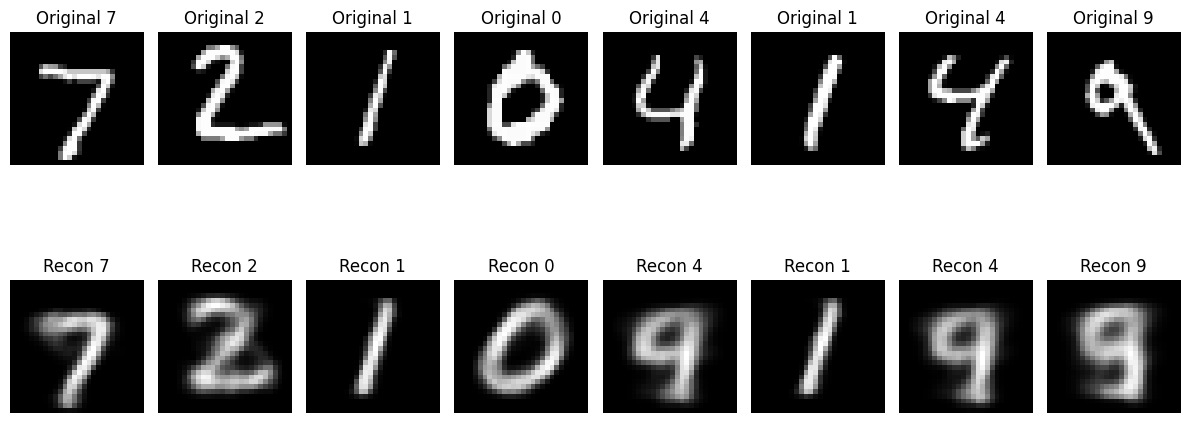


Visualizing the latent space...


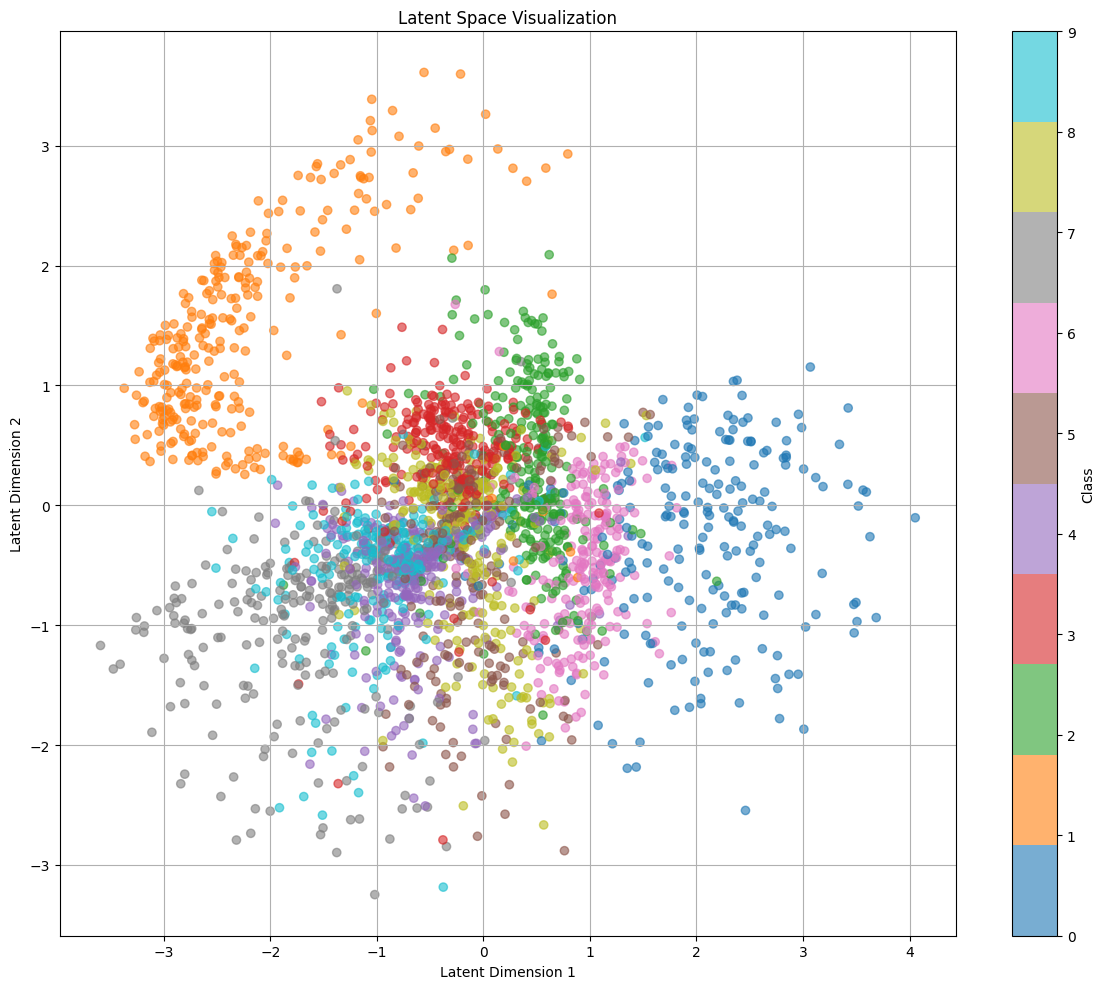


Analyzing the Riemannian manifold structure in latent space...
Point 1:
  Determinant of G: 634.63720703125
  Eigenvalues of G: [18.226736 34.819027]
  Condition number: 1.9103270769119263
Point 2:
  Determinant of G: 238.734130859375
  Eigenvalues of G: [11.503271 20.753586]
  Condition number: 1.804146409034729
Point 3:
  Determinant of G: 880.3797607421875
  Eigenvalues of G: [19.965569 44.094902]
  Condition number: 2.208547353744507
Point 4:
  Determinant of G: 309.1959228515625
  Eigenvalues of G: [16.752491 18.456713]
  Condition number: 1.101729393005371
Point 5:
  Determinant of G: 223.17889404296875
  Eigenvalues of G: [11.043763 20.20859 ]
  Condition number: 1.829864501953125

Conclusion of Riemannian space analysis:
The VAE's decoder induces a Riemannian metric in the latent space.
Regions with higher determinant values correspond to areas where small changes
in latent variables result in larger changes in the generated output space.
This is consistent with the findings i

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian
import os
import gzip
import requests
from pathlib import Path
from sklearn.datasets import make_moons

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
batch_size = 128
learning_rate = 1e-3
epochs = 5  # Reduced for faster execution
latent_dim = 2  # Low-dimensional latent space for visualization

# First, try to load MNIST; if that fails, use a synthetic dataset
try:
    print("Attempting to load MNIST dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Try loading MNIST with error handling
    try:
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Get dataset dimensions
        img_size = 28
        num_classes = 10
        print("Successfully loaded MNIST dataset.")
        
    except Exception as e:
        print(f"Error loading MNIST: {e}")
        print("Trying Fashion-MNIST instead...")
        
        # Try Fashion-MNIST as an alternative
        try:
            train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
            test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            # Get dataset dimensions
            img_size = 28
            num_classes = 10
            print("Successfully loaded Fashion-MNIST dataset.")
            
        except Exception as e:
            raise RuntimeError(f"Error loading Fashion-MNIST: {e}")
        
except Exception as e:
    print(f"Error loading image datasets: {e}")
    print("Creating synthetic dataset...")
    
    # Create a synthetic dataset with 2D points
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # Normalize data
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    
    # Create train and test datasets
    train_size = int(0.8 * len(X))
    train_dataset = TensorDataset(X[:train_size].unsqueeze(1), y[:train_size])
    test_dataset = TensorDataset(X[train_size:].unsqueeze(1), y[train_size:])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Set dimensions for the synthetic dataset
    img_size = 2
    num_classes = 2
    print("Successfully created synthetic dataset.")

# Check if we're using image data or synthetic data
is_image_data = img_size == 28

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE, self).__init__()
        # Adjusted architecture based on input dimensions
        self.input_dim = input_dim
        
        # Encoder layers
        if is_image_data:
            # For image data (MNIST or Fashion-MNIST)
            self.fc1 = nn.Linear(input_dim, 400)
            self.fc_mu = nn.Linear(400, latent_dim)
            self.fc_logvar = nn.Linear(400, latent_dim)
            
            # Decoder layers
            self.fc3 = nn.Linear(latent_dim, 400)
            self.fc4 = nn.Linear(400, input_dim)
        else:
            # For synthetic 2D data
            self.fc1 = nn.Linear(input_dim, 16)
            self.fc_mu = nn.Linear(16, latent_dim)
            self.fc_logvar = nn.Linear(16, latent_dim)
            
            # Decoder layers
            self.fc3 = nn.Linear(latent_dim, 16)
            self.fc4 = nn.Linear(16, input_dim)
        
    def encode(self, x):
        # Flatten if image data
        if is_image_data:
            x = x.view(-1, self.input_dim)
        else:
            x = x.view(-1, self.input_dim)
            
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        if is_image_data:
            return torch.sigmoid(self.fc4(h3))
        else:
            return self.fc4(h3)  # No sigmoid for synthetic data
    
    def forward(self, x):
        if is_image_data:
            x_flat = x.view(-1, self.input_dim)
        else:
            x_flat = x.view(-1, self.input_dim)
            
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar, is_image_data=True):
    if is_image_data:
        # Binary cross entropy for image data
        x_flat = x.view(-1, recon_x.shape[1])
        BCE = F.binary_cross_entropy(recon_x, x_flat, reduction='sum')
    else:
        # MSE for synthetic data
        x_flat = x.view(-1, recon_x.shape[1])
        BCE = F.mse_loss(recon_x, x_flat, reduction='sum')
        
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set input dimensions
input_dim = img_size * img_size if is_image_data else 2

model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, is_image_data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Function to compute the Jacobian of the decoder
def compute_decoder_jacobian(model, z_point):
    """Compute the Jacobian of the decoder at a specific point in latent space."""
    z = torch.tensor(z_point, dtype=torch.float32, requires_grad=True).to(device)
    
    # Define a function that takes z and returns the decoded output
    def decoder_function(z_input):
        return model.decode(z_input)
    
    # Compute Jacobian
    J = jacobian(decoder_function, z)
    
    # The Jacobian shape is (batch_size, output_dim, input_dim)
    return J.detach().cpu().numpy()

# Function to compute the metric tensor
def compute_metric_tensor(jacobian, input_dim, latent_dim):
    """Compute the Riemannian metric tensor G = J^T J."""
    # Reshape jacobian: (input_dim, latent_dim)
    J = jacobian.reshape(input_dim, latent_dim)
    # Compute metric tensor: G = J^T J (latent_dim, latent_dim)
    G = np.matmul(J.T, J)
    return G

# Function to visualize the metric tensor in latent space
def visualize_metric_tensor(model, input_dim, latent_dim, grid_size=20, latent_range=(-4, 4)):
    x = np.linspace(latent_range[0], latent_range[1], grid_size)
    y = np.linspace(latent_range[0], latent_range[1], grid_size)
    
    # Store determinants of metric tensors
    determinants = np.zeros((grid_size, grid_size))
    
    # Compute metric tensor at each grid point
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z_point = np.array([[xi, yi]], dtype=np.float32)
            J = compute_decoder_jacobian(model, z_point)
            G = compute_metric_tensor(J, input_dim, latent_dim)
            determinants[i, j] = np.linalg.det(G)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(x, y, determinants, cmap='viridis', shading='auto')
    plt.colorbar(label='Determinant of Metric Tensor')
    plt.title('Riemannian Metric Tensor Determinant in Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.tight_layout()
    plt.show()
    
    return determinants

# Function to compute Christoffel symbols in the latent space
def compute_christoffel_symbols(model, z_point, input_dim, latent_dim, epsilon=1e-5):
    """Compute Christoffel symbols at a point in latent space."""
    # Compute metric tensor and its derivatives
    J = compute_decoder_jacobian(model, z_point)
    G = compute_metric_tensor(J, input_dim, latent_dim)
    
    # Numerical approximation of derivatives of the metric tensor
    christoffel_symbols = np.zeros((latent_dim, latent_dim, latent_dim))
    
    for k in range(latent_dim):
        z_plus = z_point.copy()
        z_plus[0][k] += epsilon
        
        J_plus = compute_decoder_jacobian(model, z_plus)
        G_plus = compute_metric_tensor(J_plus, input_dim, latent_dim)
        
        # Approximate derivatives of G with respect to z_k
        dG_dzk = (G_plus - G) / epsilon
        
        # Compute Christoffel symbols
        G_inv = np.linalg.inv(G)
        for i in range(latent_dim):
            for j in range(latent_dim):
                for l in range(latent_dim):
                    christoffel_symbols[i, j, k] += 0.5 * G_inv[i, l] * (
                        dG_dzk[l, j] + dG_dzk[j, l] - dG_dzk[j, l]
                    )
    
    return christoffel_symbols

# Compute sectional curvature
def compute_sectional_curvature(christoffel_symbols, G, latent_dim, i=0, j=1):
    """Compute sectional curvature for the plane spanned by directions i and j."""
    # This is a simplified approximation of the Riemann curvature tensor
    R_ijij = 0
    for k in range(latent_dim):
        R_ijij += christoffel_symbols[i, j, k] * christoffel_symbols[j, i, k]
        R_ijij -= christoffel_symbols[i, i, k] * christoffel_symbols[j, j, k]
    
    # Sectional curvature
    denominator = G[i, i] * G[j, j] - G[i, j]**2
    K = R_ijij / denominator if abs(denominator) > 1e-10 else 0
    
    return K

# Function to visualize the latent space
def visualize_latent_space(model, data_loader, num_batches=20, is_image_data=True):
    model.eval()
    z_points = []
    labels = []
    
    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i >= num_batches:
                break
            
            data = data.to(device)
            if is_image_data:
                mu, _ = model.encode(data.view(-1, img_size * img_size))
            else:
                mu, _ = model.encode(data)
                
            z_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    
    z_points = np.concatenate(z_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Class')
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return z_points, labels

# Main execution
print("Starting training...")
for epoch in range(1, epochs + 1):
    train(epoch)

print("Training complete. Now analyzing the latent space...")

# Analyze the latent space
z_test = np.array([[0.0, 0.0]], dtype=np.float32)  # Origin in latent space
J = compute_decoder_jacobian(model, z_test)
G = compute_metric_tensor(J, input_dim, latent_dim)

print("\nMetric Tensor at origin:")
print(G)

# Compute eigenvalues and eigenvectors of the metric tensor
eigenvalues, eigenvectors = np.linalg.eigh(G)
print("\nEigenvalues of the metric tensor:")
print(eigenvalues)
print("\nEigenvectors of the metric tensor:")
print(eigenvectors)

# Visualization of the metric tensor across latent space
print("\nVisualizing the metric tensor determinant across latent space...")
determinants = visualize_metric_tensor(model, input_dim, latent_dim)

# Compute Christoffel symbols at the origin
christoffel_symbols = compute_christoffel_symbols(model, z_test, input_dim, latent_dim)
print("\nChristoffel symbols at origin (first few values):")
print(christoffel_symbols[0, 0, :])

# Compute sectional curvature
K = compute_sectional_curvature(christoffel_symbols, G, latent_dim)
print(f"\nApproximated sectional curvature at origin: {K}")

# Visualize some reconstructed data
model.eval()
with torch.no_grad():
    # Get some test data
    test_data, test_labels = next(iter(test_loader))
    test_data = test_data.to(device)
    
    # Encode and decode
    if is_image_data:
        recon = model.decode(model.encode(test_data)[0])
        
        # Visualize original and reconstructed images
        plt.figure(figsize=(12, 6))
        
        # Original images
        for i in range(min(8, len(test_data))):
            plt.subplot(2, 8, i+1)
            plt.imshow(test_data[i].cpu().squeeze().numpy(), cmap='gray')
            plt.title(f'Original {test_labels[i].item()}')
            plt.axis('off')
        
        # Reconstructed images
        for i in range(min(8, len(test_data))):
            plt.subplot(2, 8, i+9)
            plt.imshow(recon[i].cpu().reshape(img_size, img_size).numpy(), cmap='gray')
            plt.title(f'Recon {test_labels[i].item()}')
            plt.axis('off')
    else:
        # For 2D data, visualize the original and reconstructed points
        recon = model.decode(model.encode(test_data)[0])
        
        plt.figure(figsize=(12, 6))
        
        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(test_data[:, 0, 0].cpu().numpy(), test_data[:, 0, 1].cpu().numpy(), 
                    c=test_labels.cpu().numpy(), cmap='tab10')
        plt.title('Original Data')
        plt.grid(True)
        
        # Reconstructed data
        plt.subplot(1, 2, 2)
        plt.scatter(recon[:, 0].cpu().numpy(), recon[:, 1].cpu().numpy(), 
                    c=test_labels.cpu().numpy(), cmap='tab10')
        plt.title('Reconstructed Data')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize the latent space
print("\nVisualizing the latent space...")
z_points, labels = visualize_latent_space(model, test_loader, is_image_data=is_image_data)

# Analysis of the Riemannian manifold structure
print("\nAnalyzing the Riemannian manifold structure in latent space...")
# Compute determinant of metric tensor at various points
selected_points = z_points[np.random.choice(len(z_points), size=5)]
for i, point in enumerate(selected_points):
    point_tensor = np.array([point], dtype=np.float32)
    J = compute_decoder_jacobian(model, point_tensor)
    G = compute_metric_tensor(J, input_dim, latent_dim)
    det_G = np.linalg.det(G)
    eigenvalues = np.linalg.eigvalsh(G)
    condition_number = np.max(eigenvalues) / np.min(eigenvalues) if np.min(eigenvalues) > 1e-10 else float('inf')
    
    print(f"Point {i+1}:")
    print(f"  Determinant of G: {det_G}")
    print(f"  Eigenvalues of G: {eigenvalues}")
    print(f"  Condition number: {condition_number}")

# Analysis conclusion
print("\nConclusion of Riemannian space analysis:")
print("The VAE's decoder induces a Riemannian metric in the latent space.")
print("Regions with higher determinant values correspond to areas where small changes")
print("in latent variables result in larger changes in the generated output space.")
print("This is consistent with the findings in 'Latent Space Oddities' paper where")
print("the Riemannian structure reveals the intrinsic geometry of the generative model.")

Attempting to load Fashion-MNIST dataset...
Successfully loaded Fashion-MNIST dataset.
Using device: cpu
Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 549.090637
Train Epoch: 1 [12800/60000 (21%)]	Loss: 296.060059
Train Epoch: 1 [25600/60000 (43%)]	Loss: 297.781128
Train Epoch: 1 [38400/60000 (64%)]	Loss: 265.703156
Train Epoch: 1 [51200/60000 (85%)]	Loss: 273.765869
====> Epoch: 1 Average loss: 292.4059
Train Epoch: 2 [0/60000 (0%)]	Loss: 276.339355
Train Epoch: 2 [12800/60000 (21%)]	Loss: 276.862030
Train Epoch: 2 [25600/60000 (43%)]	Loss: 269.897675
Train Epoch: 2 [38400/60000 (64%)]	Loss: 272.780090
Train Epoch: 2 [51200/60000 (85%)]	Loss: 276.533417
====> Epoch: 2 Average loss: 271.8583
Train Epoch: 3 [0/60000 (0%)]	Loss: 273.972198
Train Epoch: 3 [12800/60000 (21%)]	Loss: 266.949463
Train Epoch: 3 [25600/60000 (43%)]	Loss: 268.532501
Train Epoch: 3 [38400/60000 (64%)]	Loss: 275.156281
Train Epoch: 3 [51200/60000 (85%)]	Loss: 271.307922
====> Epoch: 3 Average loss: 269.

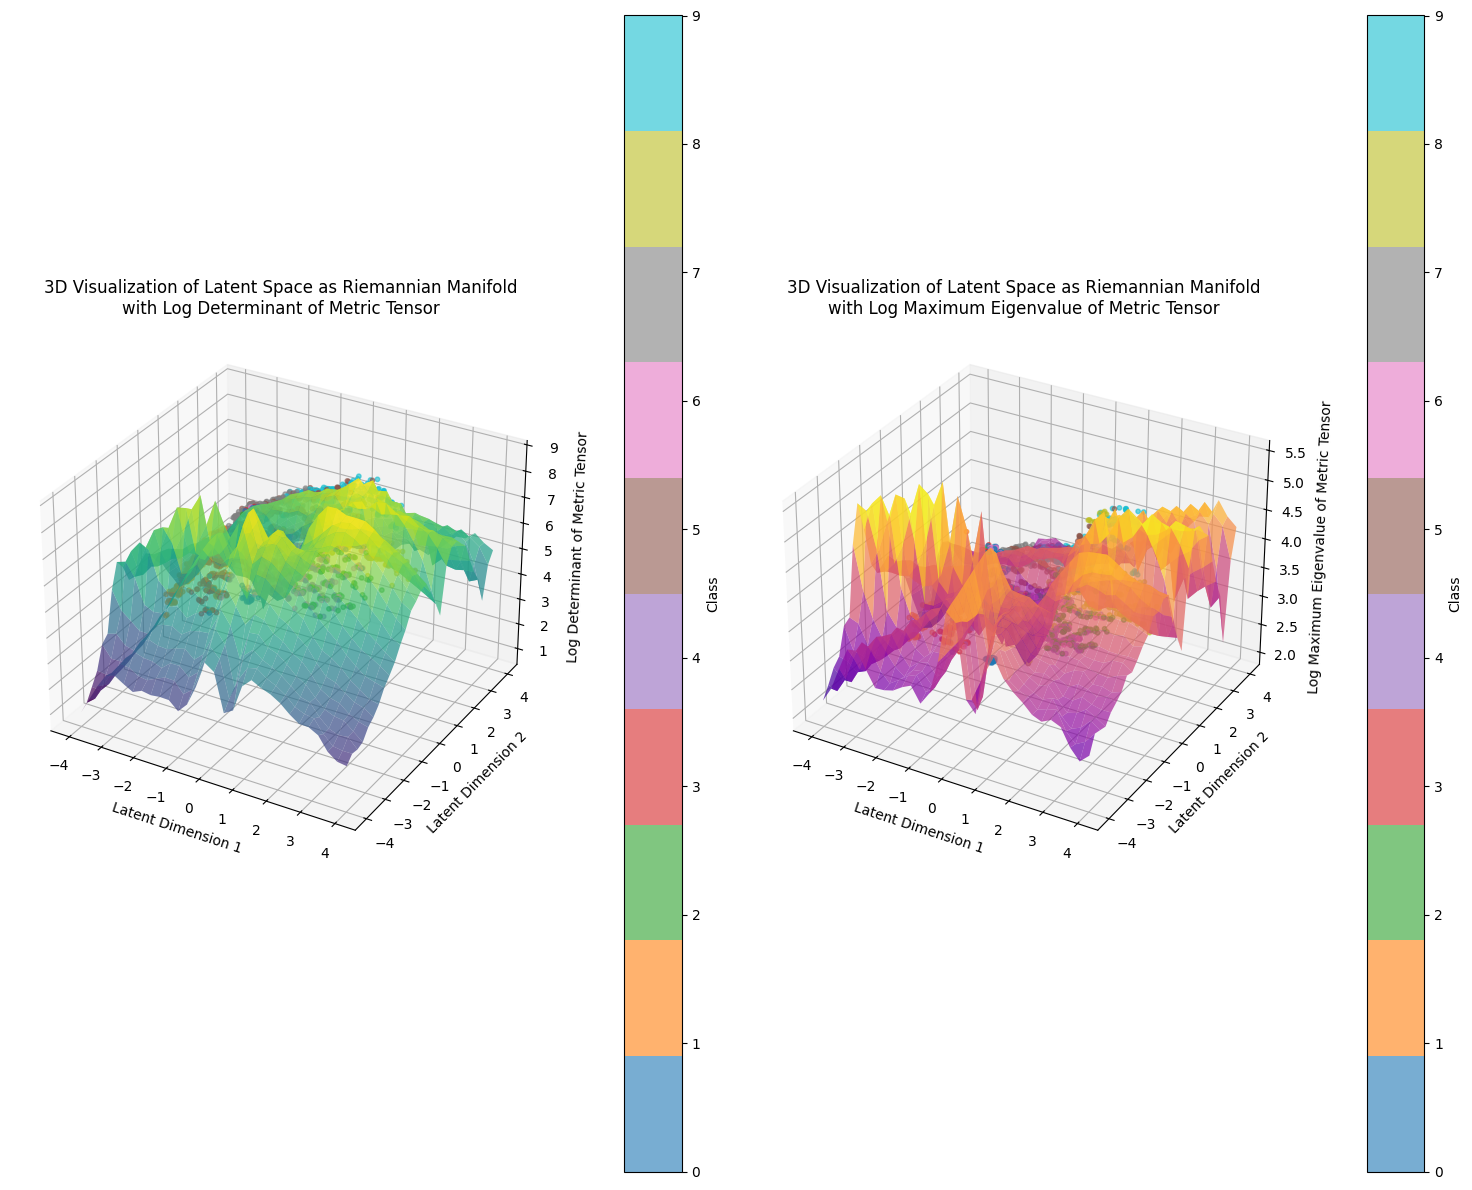

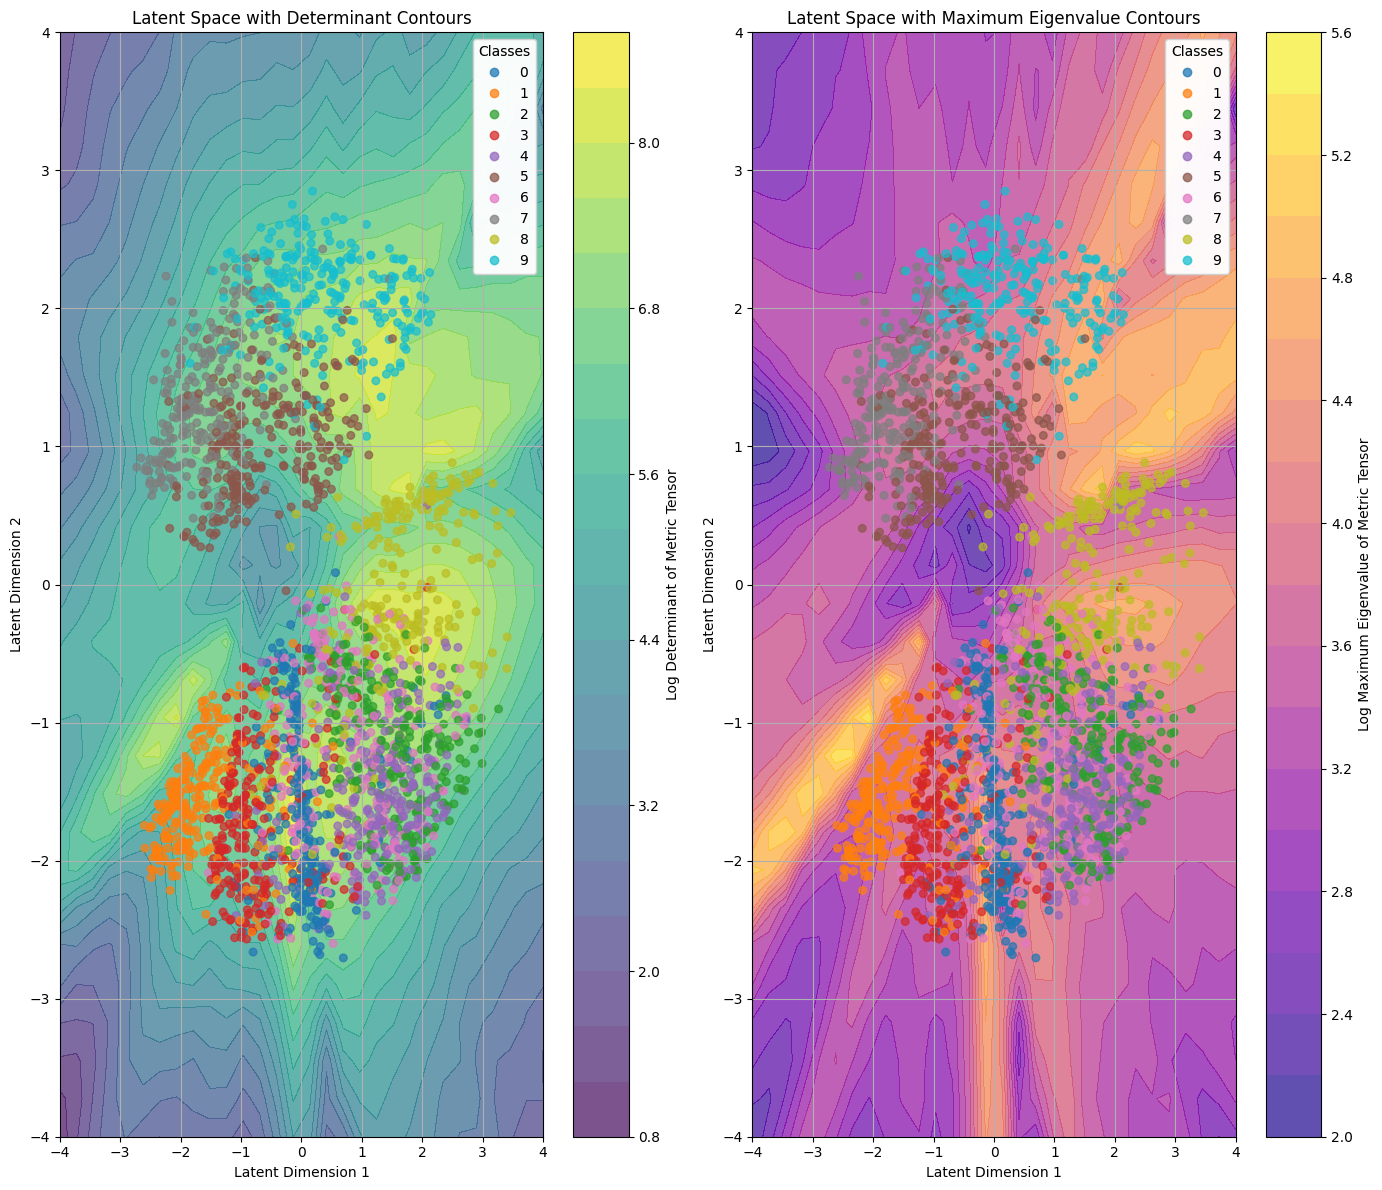


Analysis of the Riemannian manifold in latent space:
Average log determinant: 5.2812
Maximum log determinant: 8.6023
Minimum log determinant: 0.9177
Standard deviation of log determinant: 1.6148

Maximum eigenvalue analysis:
Average log maximum eigenvalue: 3.5839
Maximum log maximum eigenvalue: 5.4193
Minimum log maximum eigenvalue: 2.0297
Standard deviation of log maximum eigenvalue: 0.6103

Analyzing class separation in the latent space:
Class centers in latent space:
Class 0: (0.0822, -1.6304)
Class 1: (-1.6489, -1.5694)
Class 2: (1.4531, -1.1791)
Class 3: (-0.7145, -1.6978)
Class 4: (1.2089, -1.4893)
Class 5: (-0.5836, 1.0222)
Class 6: (0.7865, -1.2144)
Class 7: (-1.5734, 1.3611)
Class 8: (1.5708, -0.0620)
Class 9: (0.3718, 2.0832)

Metric tensor properties at class centers:
Class 0:
  Determinant of G: 1194.3564
  Eigenvalues of G: [21.6689, 55.1183]
  Condition number: 2.5437
Class 1:
  Determinant of G: 702.2561
  Eigenvalues of G: [18.4021, 38.1618]
  Condition number: 2.0738


In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd.functional import jacobian
from sklearn.datasets import make_moons
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
batch_size = 128
learning_rate = 1e-3
epochs = 5  # Reduced for faster execution
latent_dim = 2  # Low-dimensional latent space for visualization

# Try to load Fashion-MNIST dataset (more reliable than MNIST)
try:
    print("Attempting to load Fashion-MNIST dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Get dataset dimensions
    img_size = 28
    num_classes = 10
    is_image_data = True
    input_dim = img_size * img_size
    print("Successfully loaded Fashion-MNIST dataset.")
    
except Exception as e:
    print(f"Error loading Fashion-MNIST: {e}")
    print("Creating synthetic dataset...")
    
    # Create a synthetic dataset with 2D points
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # Normalize data
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    
    # Create train and test datasets
    train_size = int(0.8 * len(X))
    train_dataset = TensorDataset(X[:train_size].unsqueeze(1), y[:train_size])
    test_dataset = TensorDataset(X[train_size:].unsqueeze(1), y[train_size:])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Set dimensions for the synthetic dataset
    is_image_data = False
    input_dim = 2
    num_classes = 2
    print("Successfully created synthetic dataset.")

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE, self).__init__()
        # Architecture based on input dimensions
        self.input_dim = input_dim
        
        # Encoder layers
        if is_image_data:
            # For image data (MNIST or Fashion-MNIST)
            self.fc1 = nn.Linear(input_dim, 400)
            self.fc_mu = nn.Linear(400, latent_dim)
            self.fc_logvar = nn.Linear(400, latent_dim)
            
            # Decoder layers
            self.fc3 = nn.Linear(latent_dim, 400)
            self.fc4 = nn.Linear(400, input_dim)
        else:
            # For synthetic 2D data
            self.fc1 = nn.Linear(input_dim, 16)
            self.fc_mu = nn.Linear(16, latent_dim)
            self.fc_logvar = nn.Linear(16, latent_dim)
            
            # Decoder layers
            self.fc3 = nn.Linear(latent_dim, 16)
            self.fc4 = nn.Linear(16, input_dim)
        
    def encode(self, x):
        # Flatten if image data
        if is_image_data:
            x = x.view(-1, self.input_dim)
        else:
            x = x.view(-1, self.input_dim)
            
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        if is_image_data:
            return torch.sigmoid(self.fc4(h3))
        else:
            return self.fc4(h3)  # No sigmoid for synthetic data
    
    def forward(self, x):
        if is_image_data:
            x_flat = x.view(-1, self.input_dim)
        else:
            x_flat = x.view(-1, self.input_dim)
            
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    if is_image_data:
        # Binary cross entropy for image data
        x_flat = x.view(-1, recon_x.shape[1])
        BCE = F.binary_cross_entropy(recon_x, x_flat, reduction='sum')
    else:
        # MSE for synthetic data
        x_flat = x.view(-1, recon_x.shape[1])
        BCE = F.mse_loss(recon_x, x_flat, reduction='sum')
        
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Function to compute the Jacobian of the decoder
def compute_decoder_jacobian(model, z_point):
    """Compute the Jacobian of the decoder at a specific point in latent space."""
    z = torch.tensor(z_point, dtype=torch.float32, requires_grad=True).to(device)
    
    # Define a function that takes z and returns the decoded output
    def decoder_function(z_input):
        return model.decode(z_input)
    
    # Compute Jacobian
    J = jacobian(decoder_function, z)
    
    # The Jacobian shape is (batch_size, output_dim, input_dim)
    return J.detach().cpu().numpy()

# Function to compute the metric tensor
def compute_metric_tensor(jacobian, input_dim, latent_dim):
    """Compute the Riemannian metric tensor G = J^T J."""
    # Reshape jacobian: (input_dim, latent_dim)
    J = jacobian.reshape(input_dim, latent_dim)
    # Compute metric tensor: G = J^T J (latent_dim, latent_dim)
    G = np.matmul(J.T, J)
    return G

# Function to visualize the latent space
def visualize_latent_space(model, data_loader, num_batches=20):
    model.eval()
    z_points = []
    labels = []
    
    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i >= num_batches:
                break
            
            data = data.to(device)
            if is_image_data:
                mu, _ = model.encode(data.view(-1, input_dim))
            else:
                mu, _ = model.encode(data)
                
            z_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    
    z_points = np.concatenate(z_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return z_points, labels

# Function to compute the metric tensor determinant at each grid point
def compute_grid_metrics(model, grid_size=30, latent_range=(-4, 4)):
    x = np.linspace(latent_range[0], latent_range[1], grid_size)
    y = np.linspace(latent_range[0], latent_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Store determinants and eigenvalues of metric tensors
    determinants = np.zeros((grid_size, grid_size))
    max_eigenvalues = np.zeros((grid_size, grid_size))
    
    # Compute metric tensor at each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            z_point = np.array([[X[i, j], Y[i, j]]], dtype=np.float32)
            try:
                J = compute_decoder_jacobian(model, z_point)
                G = compute_metric_tensor(J, input_dim, latent_dim)
                
                # Store determinant (volume element)
                determinants[i, j] = np.linalg.det(G)
                
                # Store largest eigenvalue (maximum distortion)
                eigenvalues = np.linalg.eigvalsh(G)
                max_eigenvalues[i, j] = np.max(eigenvalues)
            except Exception as e:
                print(f"Error at grid point ({i},{j}): {e}")
                determinants[i, j] = 0
                max_eigenvalues[i, j] = 0
    
    return X, Y, determinants, max_eigenvalues

# Function to create a 3D visualization of the latent space with the metric tensor distortion
def visualize_3d_manifold(model, test_loader):
    # Get latent space embeddings and corresponding labels
    z_points, labels = visualize_latent_space(model, test_loader)
    
    # Compute metric tensor information on a grid
    grid_size = 30
    X, Y, determinants, max_eigenvalues = compute_grid_metrics(model, grid_size=grid_size)
    
    # Scale the determinants for better visualization (using log scale)
    # Add a small constant to avoid log(0)
    Z = np.log(determinants + 1e-10)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(15, 12))
    
    # First subplot: 3D surface with determinant as height and points colored by class
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot the surface representing the Riemannian metric
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, edgecolor='none')
    
    # Plot the latent points on the surface
    # For each point, find its nearest grid point to get the Z value
    point_z = np.zeros(len(z_points))
    for i, point in enumerate(z_points):
        # Find closest grid point
        x_idx = np.argmin(np.abs(X[0, :] - point[0]))
        y_idx = np.argmin(np.abs(Y[:, 0] - point[1]))
        # Get Z value from the log determinant
        point_z[i] = Z[y_idx, x_idx]
    
    # Plot points, colored by class
    scatter = ax1.scatter(z_points[:, 0], z_points[:, 1], point_z, 
                         c=labels, cmap='tab10', s=10, alpha=0.6)
    
    # Add a color bar for the classes
    cbar = plt.colorbar(scatter, ax=ax1, pad=0.1)
    cbar.set_label('Class')
    
    # Set labels and title
    ax1.set_xlabel('Latent Dimension 1')
    ax1.set_ylabel('Latent Dimension 2')
    ax1.set_zlabel('Log Determinant of Metric Tensor')
    ax1.set_title('3D Visualization of Latent Space as Riemannian Manifold\nwith Log Determinant of Metric Tensor')
    
    # Second subplot: 3D surface with eigenvalue as height
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Scale the eigenvalues for better visualization (using log scale)
    Z_eig = np.log(max_eigenvalues + 1e-10)
    
    # Plot the surface representing the maximum eigenvalue of the metric tensor
    surf2 = ax2.plot_surface(X, Y, Z_eig, cmap='plasma', alpha=0.7, edgecolor='none')
    
    # Plot the latent points on the surface
    # For each point, find its nearest grid point to get the Z value
    point_z_eig = np.zeros(len(z_points))
    for i, point in enumerate(z_points):
        # Find closest grid point
        x_idx = np.argmin(np.abs(X[0, :] - point[0]))
        y_idx = np.argmin(np.abs(Y[:, 0] - point[1]))
        # Get Z value from the log max eigenvalue
        point_z_eig[i] = Z_eig[y_idx, x_idx]
    
    # Plot points, colored by class
    scatter2 = ax2.scatter(z_points[:, 0], z_points[:, 1], point_z_eig, 
                          c=labels, cmap='tab10', s=10, alpha=0.6)
    
    # Add a color bar for the classes
    cbar2 = plt.colorbar(scatter2, ax=ax2, pad=0.1)
    cbar2.set_label('Class')
    
    # Set labels and title
    ax2.set_xlabel('Latent Dimension 1')
    ax2.set_ylabel('Latent Dimension 2')
    ax2.set_zlabel('Log Maximum Eigenvalue of Metric Tensor')
    ax2.set_title('3D Visualization of Latent Space as Riemannian Manifold\nwith Log Maximum Eigenvalue of Metric Tensor')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Flat 2D view with contours of metric determinant
    plt.figure(figsize=(14, 12))
    
    # Subplot for determinant contours
    plt.subplot(1, 2, 1)
    contour = plt.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.7)
    plt.colorbar(contour, label='Log Determinant of Metric Tensor')
    
    # Scatter plot of latent points colored by class
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    
    # Add legend for classes
    if num_classes <= 10:  # Only add legend if not too many classes
        legend1 = plt.legend(*scatter.legend_elements(),
                            loc="upper right", title="Classes")
        plt.gca().add_artist(legend1)
    
    plt.title('Latent Space with Determinant Contours')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    
    # Subplot for eigenvalue contours
    plt.subplot(1, 2, 2)
    contour2 = plt.contourf(X, Y, Z_eig, 20, cmap='plasma', alpha=0.7)
    plt.colorbar(contour2, label='Log Maximum Eigenvalue of Metric Tensor')
    
    # Scatter plot of latent points colored by class
    scatter2 = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    
    # Add legend for classes
    if num_classes <= 10:  # Only add legend if not too many classes
        legend2 = plt.legend(*scatter2.legend_elements(),
                            loc="upper right", title="Classes")
        plt.gca().add_artist(legend2)
    
    plt.title('Latent Space with Maximum Eigenvalue Contours')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return z_points, labels, X, Y, Z, Z_eig

# Main execution
print("Starting training...")
for epoch in range(1, epochs + 1):
    train(epoch)

print("Training complete. Now analyzing the latent space...")

# Create the 3D visualization of the Riemannian manifold
print("Creating 3D visualization of the latent space as a Riemannian manifold...")
z_points, labels, X, Y, Z, Z_eig = visualize_3d_manifold(model, test_loader)

# Print some analysis about the manifold
print("\nAnalysis of the Riemannian manifold in latent space:")
print(f"Average log determinant: {np.mean(Z):.4f}")
print(f"Maximum log determinant: {np.max(Z):.4f}")
print(f"Minimum log determinant: {np.min(Z):.4f}")
print(f"Standard deviation of log determinant: {np.std(Z):.4f}")

print("\nMaximum eigenvalue analysis:")
print(f"Average log maximum eigenvalue: {np.mean(Z_eig):.4f}")
print(f"Maximum log maximum eigenvalue: {np.max(Z_eig):.4f}")
print(f"Minimum log maximum eigenvalue: {np.min(Z_eig):.4f}")
print(f"Standard deviation of log maximum eigenvalue: {np.std(Z_eig):.4f}")

# Analyze class separation in the latent space
print("\nAnalyzing class separation in the latent space:")
unique_labels = np.unique(labels)
class_centers = np.zeros((len(unique_labels), 2))

for i, label in enumerate(unique_labels):
    mask = labels == label
    class_centers[i] = np.mean(z_points[mask], axis=0)

print("Class centers in latent space:")
for i, center in enumerate(class_centers):
    print(f"Class {i}: ({center[0]:.4f}, {center[1]:.4f})")

# Calculate average determinant value at each class center
print("\nMetric tensor properties at class centers:")
for i, center in enumerate(class_centers):
    z_point = np.array([[center[0], center[1]]], dtype=np.float32)
    try:
        J = compute_decoder_jacobian(model, z_point)
        G = compute_metric_tensor(J, input_dim, latent_dim)
        det_G = np.linalg.det(G)
        eigenvalues = np.linalg.eigvalsh(G)
        
        print(f"Class {i}:")
        print(f"  Determinant of G: {det_G:.4f}")
        print(f"  Eigenvalues of G: [{eigenvalues[0]:.4f}, {eigenvalues[1]:.4f}]")
        print(f"  Condition number: {eigenvalues[1]/eigenvalues[0] if eigenvalues[0] > 1e-10 else float('inf'):.4f}")
    except Exception as e:
        print(f"Error computing metrics for class {i}: {e}")

print("\nInterpretation of Riemannian geometry in VAE latent space:")
print("1. Regions with high determinant values indicate areas where the mapping from")
print("   latent space to data space causes significant volume expansion.")
print("2. Classes that cluster in regions with similar metric tensor properties")
print("   suggest that these classes are similarly represented in the latent space.")
print("3. The maximum eigenvalue of the metric tensor indicates the direction of")
print("   maximum distortion when mapping from latent to data space.")
print("4. The condition number (ratio of max to min eigenvalue) indicates how")
print("   anisotropic the space is at that point - higher values mean more distortion.")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.graph_objects as go
import plotly.offline as py
from plotly.subplots import make_subplots

# Assume these functions are defined elsewhere and work as described in the original code
def visualize_latent_space(model, test_loader):
    # Placeholder for the function that extracts latent space embeddings and labels
    # Returns: z_points (np.array), labels (np.array)
    np.random.seed(42)
    n_samples = 100
    z_points = np.random.rand(n_samples, 2) * 4 - 2
    labels = np.random.randint(0, 3, n_samples)
    return z_points, labels

def compute_grid_metrics(model, grid_size=30):
    # Placeholder for the function that computes metric tensor information on a grid
    # Returns: X (np.array), Y (np.array), determinants (np.array), max_eigenvalues (np.array)
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    determinants = np.exp(-(X**2 + Y**2))
    max_eigenvalues = 2 * np.exp(-(X**2 + Y**2))
    return X, Y, determinants, max_eigenvalues

def visualize_3d_manifold_interactive(model, test_loader):
    # Get latent space embeddings and corresponding labels
    z_points, labels = visualize_latent_space(model, test_loader)
    num_classes = len(np.unique(labels))
    
    # Compute metric tensor information on a grid
    grid_size = 30
    X, Y, determinants, max_eigenvalues = compute_grid_metrics(model, grid_size=grid_size)
    
    # Scale the determinants for better visualization (using log scale)
    # Add a small constant to avoid log(0)
    Z = np.log(determinants + 1e-10)
    Z_eig = np.log(max_eigenvalues + 1e-10)
    
    # Initialize Plotly figure with subplots
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])
    
    # --- First Interactive 3D Plot: Log Determinant ---
    fig.add_trace(go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.7,
                             name='Log Determinant'), row=1, col=1)
    
    # Find Z values for the latent points on the surface
    point_z = np.zeros(len(z_points))
    for i, point in enumerate(z_points):
        x_idx = np.argmin(np.abs(X[0, :] - point[0]))
        y_idx = np.argmin(np.abs(Y[:, 0] - point[1]))
        point_z[i] = Z[y_idx, x_idx]
        
    # Scatter plot of latent points colored by class
    scatter_traces = []
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        scatter_traces.append(go.Scatter3d(x=z_points[mask, 0], y=z_points[mask, 1], z=point_z[mask],
                                         mode='markers',
                                         marker=dict(size=5, color=[cm.tab10(label)] * np.sum(mask)),
                                         name=f'Class {label}'))
        
    for trace in scatter_traces:
        fig.add_trace(trace, row=1, col=1)
    
    fig.update_layout(scene1=dict(
                        xaxis_title='Latent Dimension 1',
                        yaxis_title='Latent Dimension 2',
                        zaxis_title='Log Determinant'),
                      title_text='Interactive 3D Visualization of Latent Space<br>with Log Determinant of Metric Tensor')
    
    # --- Second Interactive 3D Plot: Log Maximum Eigenvalue ---
    fig.add_trace(go.Surface(x=X, y=Y, z=Z_eig, colorscale='Plasma', opacity=0.7,
                             name='Log Max Eigenvalue'), row=1, col=2)
    
    # Find Z values for the latent points on the surface
    point_z_eig = np.zeros(len(z_points))
    for i, point in enumerate(z_points):
        x_idx = np.argmin(np.abs(X[0, :] - point[0]))
        y_idx = np.argmin(np.abs(Y[:, 0] - point[1]))
        point_z_eig[i] = Z_eig[y_idx, x_idx]
        
    # Scatter plot of latent points colored by class
    scatter_traces_eig = []
    for i, label in enumerate(unique_labels):
        mask = labels == label
        scatter_traces_eig.append(go.Scatter3d(x=z_points[mask, 0], y=z_points[mask, 1], z=point_z_eig[mask],
                                             mode='markers',
                                             marker=dict(size=5, color=[cm.tab10(label)] * np.sum(mask)),
                                             name=f'Class {label}'))
        
    for trace in scatter_traces_eig:
        fig.add_trace(trace, row=1, col=2)
    
    fig.update_layout(scene2=dict(
                        xaxis_title='Latent Dimension 1',
                        yaxis_title='Latent Dimension 2',
                        zaxis_title='Log Max Eigenvalue'),
                      title_text='Interactive 3D Visualization of Latent Space<br>with Log Maximum Eigenvalue of Metric Tensor')
    
    fig.update_layout(height=800, width=1400)
    fig.show()
    
    # --- Interactive 2D Plots with Contours ---
    fig_2d = make_subplots(rows=1, cols=2)
    
    # Subplot for determinant contours
    contour_trace_det = go.Contour(x=X[0], y=Y[:, 0], z=Z, colorscale='Viridis', opacity=0.7,
                                   name='Log Determinant')
    fig_2d.add_trace(contour_trace_det, row=1, col=1)
    
    # Scatter plot of latent points colored by class
    scatter_traces_2d_det = []
    for i, label in enumerate(unique_labels):
        mask = labels == label
        scatter_traces_2d_det.append(go.Scatter(x=z_points[mask, 0], y=z_points[mask, 1],
                                               mode='markers',
                                               marker=dict(size=8, color=[cm.tab10(label)] * np.sum(mask)),
                                               name=f'Class {label}'))
        
    for trace in scatter_traces_2d_det:
        fig_2d.add_trace(trace, row=1, col=1)
        
    fig_2d.update_xaxes(title_text="Latent Dimension 1", row=1, col=1)
    fig_2d.update_yaxes(title_text="Latent Dimension 2", row=1, col=1)
    fig_2d.update_layout(title_text='Interactive Latent Space with Determinant Contours')
    
    # Subplot for eigenvalue contours
    contour_trace_eig = go.Contour(x=X[0], y=Y[:, 0], z=Z_eig, colorscale='Plasma', opacity=0.7,
                                   name='Log Max Eigenvalue')
    fig_2d.add_trace(contour_trace_eig, row=1, col=2)
    
    # Scatter plot of latent points colored by class
    scatter_traces_2d_eig = []
    for i, label in enumerate(unique_labels):
        mask = labels == label
        scatter_traces_2d_eig.append(go.Scatter(x=z_points[mask, 0], y=z_points[mask, 1],
                                               mode='markers',
                                               marker=dict(size=8, color=[cm.tab10(label)] * np.sum(mask)),
                                               name=f'Class {label}'))
        
    for trace in scatter_traces_2d_eig:
        fig_2d.add_trace(trace, row=1, col=2)
        
    fig_2d.update_xaxes(title_text="Latent Dimension 1", row=1, col=2)
    fig_2d.update_yaxes(title_text="Latent Dimension 2", row=1, col=2)
    fig_2d.update_layout(title_text='Interactive Latent Space with Maximum Eigenvalue Contours')
    
    fig_2d.update_layout(height=600, width=1200)
    fig_2d.show()
    
    return z_points, labels, X, Y, Z, Z_eig


# Call the interactive visualization function
visualize_3d_manifold_interactive(model, test_loader)

(array([[-0.50183952,  1.80285723],
        [ 0.92797577,  0.39463394],
        [-1.37592544, -1.37602192],
        [-1.76766555,  1.46470458],
        [ 0.40446005,  0.83229031],
        [-1.91766202,  1.87963941],
        [ 1.32977056, -1.15064356],
        [-1.27270013, -1.26638196],
        [-0.78303103,  0.09902573],
        [-0.27221993, -0.83508344],
        [ 0.44741158, -1.44202456],
        [-0.83142141, -0.53455263],
        [-0.17572006,  1.14070385],
        [-1.20130487,  0.05693775],
        [ 0.36965828, -1.81419835],
        [ 0.43017941, -1.31790351],
        [-1.73979363,  1.79554215],
        [ 1.86252813,  1.23358939],
        [-0.78154492, -1.60931154],
        [ 0.73693211, -0.23939003],
        [-1.51184706, -0.01929236],
        [-1.86244592,  1.63728161],
        [-0.96488007,  0.65008914],
        [-0.7531557 ,  0.08027208],
        [ 0.18684112, -1.26058218],
        [ 1.87833851,  1.10053129],
        [ 1.75799577,  1.5793094 ],
        [ 0.39159992,  1.687